# **XAI4Spectra**

# **Loading data**

In [75]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import kennard_stone as ks


# loading a soil spectral dataset based on X-ray fluorescence (XRF)

data_complete = pd.read_csv('https://raw.githubusercontent.com/joseviniciusr/XAI4Spectra/refs/heads/main/XRFspectra.csv', sep=';') # Toledo 2022 dataset
data = data_complete.loc[:, '1':'15']
data.insert(0, 'exCa', data_complete['exCa'])  # inserting the target variable (e.g., exCa (exchangeable calcium))

## **PLS- (R or DA) modeling**

In [76]:
def vip_scores(pls_model):
    """
    Calculate VIP (Variable Importance in Projection) scores for a fitted PLS model.
    Parameters
    ----------
    - **pls_model** : fitted PLS model object from sklearn.cross_decomposition.PLSRegression
        The PLS model for which to calculate VIP scores.
    Returns
    -------
    - vip_scores : ndarray, shape (n_features,)
        VIP scores for each feature in the model.
    """
    import numpy as np

    t = pls_model.x_scores_ # X scores 
    w = pls_model.x_weights_ # X weights
    p = pls_model.y_loadings_ # Y loadings
    features, _ = w.shape # number of features
    vip = np.zeros(shape=(features,)) # initializing VIP scores array
    inner_sum = np.diag(t.T @ t @ p.T @ p) # inner sum calculation
    SS_total = np.sum(inner_sum) # total sum of squares
    vip = np.sqrt(features*(w**2 @ inner_sum)/ SS_total) # VIP calculation
    return pd.DataFrame(vip)

def explained_variance_from_scores(X, T, P, Q=None, Y=None):
    """
    Calculate percent variance explained (based on PCTVAR Matlab function) for X and Y
    by using the scores T and loadings P (and optionally Q for Y).
    Parameters
    ----------
    - **X** : array-like, shape (n_samples, n_features)
        X matrix used in PLS.
    - **T** : array-like, shape (n_samples, n_components)
        Scores matrix from PLS.
    - **P** : array-like, shape (n_features, n_components)
        Loadings matrix for X from PLS.
    - **Q** : array-like, shape (n_targets, n_components), optional
        Loadings matrix for Y from PLS. Required if Yc is provided.
    - **Y** : array-like, shape (n_samples, n_targets), optional
       Y matrix used in PLS.
    Returns
    -------
    - result : dict with keys:
        - **'varX_cumulative'** : ndarray shape (n_components,)
            Percent cumulative variance of X explained by 1..j components.
        - **'varX_per_component'** : ndarray shape (n_components,)
            Percent variance of X explained per component.
        - **'varY_cumulative'** : ndarray shape (n_components,), or None
            Percent cumulative variance of Y explained by 1..j components (if Yc and Q provided).
        - **'varY_per_component'** : ndarray shape (n_components,), or None
            Percent variance of Y explained per component (if Yc and Q provided).
    """
    import numpy as np
    X = np.asarray(X, dtype=float) # X preprocessed data
    T = np.asarray(T, dtype=float) # scores
    P = np.asarray(P, dtype=float) # loadings for X

    n_comp = T.shape[1]
    TSS_X = np.sum(X ** 2) # total sum of squares of X
    if TSS_X == 0: # avoid division by zero
        raise ValueError("TSS_X == 0 (X does not have variability).")

    pctvarX_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for X

    for j in range(1, n_comp + 1): # loop over components
        Xhat_j = T[:, :j] @ P[:, :j].T # reconstructed X using j components
        SS_Xhat_j = np.sum(Xhat_j ** 2) # sum of squares of reconstructed X
        pctvarX_cum[j-1] = 100.0 * SS_Xhat_j / TSS_X # percent variance explained cumulativa
    
    # incremental (per component)
    pctvarX_per = np.empty_like(pctvarX_cum) # incremental percent variance for X
    pctvarX_per[0] = pctvarX_cum[0] # first component
    pctvarX_per[1:] = pctvarX_cum[1:] - pctvarX_cum[:-1] # rest

    # Y (if provided)
    pctvarY_cum = None # cumulative percent variance for Y
    pctvarY_per = None # incremental percent variance for Y
    if Q is not None and Y is not None: # if Y loadings and Y centered provided
        Q = np.asarray(Q, dtype=float) # loadings for Y
        Y = np.asarray(Y, dtype=float) # centered (and possibly scaled) Y
        TSS_Y = np.sum(Y ** 2) # total sum of squares of Y
        if TSS_Y == 0: # avoid division by zero
            pctvarY_cum = np.zeros(n_comp, dtype=float) # all zeros if Y has no variance
            pctvarY_per = np.zeros(n_comp, dtype=float) # all zeros
        else:
            pctvarY_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for Y
            for j in range(1, n_comp + 1): # loop over components
                Yhat_j = T[:, :j] @ Q[:, :j].T # reconstructed Y using j components
                SS_Yhat_j = np.sum(Yhat_j ** 2) # sum of squares of reconstructed Y
                pctvarY_cum[j-1] = 100.0 * SS_Yhat_j / TSS_Y # percent variance explained cumulativa
            pctvarY_per = np.empty_like(pctvarY_cum) # incremental percent variance for Y
            pctvarY_per[0] = pctvarY_cum[0] # first component
            pctvarY_per[1:] = pctvarY_cum[1:] - pctvarY_cum[:-1] # rest

        return {
            'varX_cumulative': pctvarX_cum[-1],
            'varX_per_component': pctvarX_per[-1],
            'varY_cumulative': pctvarY_cum[-1],
            'varY_per_component': pctvarY_per[-1]
            }         


def pls_optimized(Xcal, ycal, LVmax, Xpred=None, ypred=None, aim='regression', cv=10):
    """
    ## PLS optimized
    Function to fit a PLS regression or PLS-DA model with optimization of latent variables (LVs)
    using cross-validation. It calculates various performance metrics for calibration, cross-validation,
    and prediction (if provided) datasets
    **Parameters**:
    - **Xcal** : pd.DataFrame
        Calibration dataset features.
    - **ycal** : pd.Series or np.ndarray
        Calibration dataset target variable (regression) or binary class labels (classification).
    - **LVmax** : int
        Maximum number of latent variables to consider.
    - **Xpred** : pd.DataFrame, optional
        Prediction dataset features. Default is None.
    - **ypred** : pd.Series or np.ndarray, optional
        Prediction dataset target variable (regression) or binary class labels (classification). Default is None.
    - **aim** : str, optional
        Type of analysis: 'regression' for PLS regression or 'classification' for PLS-DA. Default is 'regression'.
    - **cv** : int, optional
        Number of cross-validation folds. Default is 10
        
    **Returns**:
    - **df_results** : pd.DataFrame
        DataFrame containing performance metrics for each number of latent variables.
    - **calres** : pd.DataFrame
        DataFrame containing predicted values for the calibration dataset.
    - **predres** : pd.DataFrame
        DataFrame containing predicted values for the prediction dataset (if provided).
    """

    import numpy as np
    import pandas as pd

    if aim == 'regression': # regression (PLSR)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import mean_squared_error, r2_score
        from scipy.stats import iqr

        results = [] # list to store results for each LV
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsr = PLSRegression(n_components=n_comp, scale=False)
            plsr.fit(Xcal, ycal)
            y_cal = plsr.predict(Xcal).flatten()
            calres[f'LV_{n_comp}'] = y_cal

            y_cv = cross_val_predict(plsr, Xcal, ycal, cv=cv) # cross-validated predictions
            y_cv = np.array(y_cv).flatten()

            R2_cal = r2_score(ycal, y_cal) # determination coefficient
            r2_cal = np.corrcoef(ycal, y_cal)[0, 1] ** 2 # correlation coefficient squared
            rmse_cal = np.sqrt(mean_squared_error(ycal, y_cal))
            R2_cv = r2_score(ycal, y_cv)
            r2_cv = np.corrcoef(ycal, y_cv)[0, 1] ** 2
            rmsecv = np.sqrt(mean_squared_error(ycal, y_cv))
            rpd_cv = ycal.std() / rmsecv if rmsecv != 0 else np.nan
            rpiq_cv = iqr(ycal, rng=(25, 75)) / rmsecv if rmsecv != 0 else np.nan
            bias_cv = np.sum(ycal - y_cv) / ycal.shape[0]
            SDV_cv = (ycal - y_cv) - bias_cv
            SDV_cv = np.sqrt(np.sum(SDV_cv * SDV_cv) / (ycal.shape[0] - 1)) if ycal.shape[0] > 1 else np.nan
            tbias_cv = abs(bias_cv) * (np.sqrt(ycal.shape[0]) / SDV_cv) if SDV_cv not in (0, np.nan) else np.nan
            
            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsr.x_scores_, plsr.x_loadings_,
                                               Q=plsr.y_loadings_, Y=ycal) # explained variance
            
            # vip scores
            vip = vip_scores(plsr).T
            vip.columns = plsr.feature_names_in_ # setting feature names

            if Xpred is not None and ypred is not None: # prediction set
                y_pred = plsr.predict(Xpred).flatten()
                predres[f'LV_{n_comp}'] = y_pred

                R2_pred = r2_score(ypred, y_pred) # determination coefficient
                r2_pred = np.corrcoef(ypred, y_pred)[0, 1] ** 2 # correlation coefficient squared
                rmsep = np.sqrt(mean_squared_error(ypred, y_pred))
                rpd_pred = ypred.std() / rmsep if rmsep != 0 else np.nan
                rpiq_pred = iqr(ypred, rng=(25, 75)) / rmsep if rmsep != 0 else np.nan
                bias_pred = np.sum(ypred - y_pred) / ypred.shape[0]
                SDV_pred = (ypred - y_pred) - bias_pred
                SDV_pred = np.sqrt(np.sum(SDV_pred * SDV_pred) / (ypred.shape[0] - 1)) if ypred.shape[0] > 1 else np.nan
                tbias_pred = abs(bias_pred) * (np.sqrt(ypred.shape[0]) / SDV_pred) if SDV_pred not in (0, np.nan) else np.nan
            else:
                r2_pred = rmsep = rpd_pred = rpiq_pred = bias_pred = tbias_pred = None

            results.append({
                'LVs': n_comp,
                'R2_Cal': R2_cal,
                'r2_Cal': r2_cal,
                'RMSEC': rmse_cal,
                'R2_CV': R2_cv,
                'r2_Cv': r2_cv,
                'RMSECV': rmsecv,
                'RPD_CV': rpd_cv,
                'RPIQ_CV': rpiq_cv,
                'Bias_CV': bias_cv,
                'tbias_CV': tbias_cv,
                'R2_Pred': R2_pred,
                'r2_Pred': r2_pred,
                'RMSEP': rmsep,
                'RPD_Pred': rpd_pred,
                'RPIQ_Pred': rpiq_pred,
                'Bias_Pred': bias_pred,
                'tbias_Pred': tbias_pred,
                'X_Cum_Exp_Var' : exp_var['varX_cumulative'],
                'Y_Cum_Exp_Var' : exp_var['varY_cumulative'],
                'X_Ind_Exp_Var' : exp_var['varX_per_component'],
                'Y_Ind_Exp_Var' : exp_var['varY_per_component']
            })

        model = plsr  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    elif aim == 'classification': # classification (PLS-DA)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import accuracy_score, confusion_matrix

        results = []
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        # ensure binary classes
        ycal_series = pd.Series(ycal).reset_index(drop=True) # ensure it's a Series
        unique_labels = ycal_series.unique() # unique class labels
        if len(unique_labels) != 2: # check for binary classification
            raise ValueError(f"PLS-DA (this function) expects 2 classes (binary). Found: {unique_labels}")

        label_to_num = {lab: idx for idx, lab in enumerate(unique_labels)} # mapping labels to 0 and 1
        num_to_label = {idx: lab for lab, idx in label_to_num.items()} # reverse mapping for predictions
       
        # prepare ycal numeric
        ycal_numeric = np.array([label_to_num[i] for i in ycal]) 

        # prepare ypred numeric if provided
        ypred_numeric = None
        if ypred is not None:
            ypred_numeric = np.array([label_to_num[i] for i in ypred])

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsda = PLSRegression(n_components=n_comp, scale=False)
            plsda.fit(Xcal, ycal_numeric)

            # calibration continuous predictions -> binarize
            y_cal_cont = plsda.predict(Xcal).flatten()
            y_cal_bin = (y_cal_cont >= 0.5).astype(int)
            y_cal_class = np.array([num_to_label[i] for i in y_cal_bin])
            calres[f'LV_{n_comp}'] = y_cal_class

            # cross-validated continuous predictions -> binarize
            y_cv_cont = cross_val_predict(plsda, Xcal, ycal_numeric, cv=cv)
            y_cv_cont = np.array(y_cv_cont).flatten()
            y_cv_bin = (y_cv_cont >= 0.5).astype(int)

            # metrics
            acc_cal = accuracy_score(ycal_numeric, y_cal_bin)
            cm_cal = confusion_matrix(ycal_numeric, y_cal_bin)
            # safe unpack for binary confusion matrix
            if cm_cal.size == 4:
                tn, fp, fn, tp = cm_cal.ravel()
            else:
                tn = fp = fn = tp = np.nan
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

            acc_cv = accuracy_score(ycal_numeric, y_cv_bin)
            cm_cv = confusion_matrix(ycal_numeric, y_cv_bin)
            if cm_cv.size == 4:
                tn_cv, fp_cv, fn_cv, tp_cv = cm_cv.ravel()
            else:
                tn_cv = fp_cv = fn_cv = tp_cv = np.nan
            sensitivity_cv = tp_cv / (tp_cv + fn_cv) if (tp_cv + fn_cv) > 0 else np.nan
            specificity_cv = tn_cv / (tn_cv + fp_cv) if (tn_cv + fp_cv) > 0 else np.nan

            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsda.x_scores_, plsda.x_loadings_,
                                               Q=plsda.y_loadings_, Y=ycal_numeric.reshape(-1, 1)) # explained variance

            # vip scores
            vip = vip_scores(plsda).T
            vip.columns = plsda.feature_names_in_ # setting feature names

            # prediction set (if provided)
            if Xpred is not None and ypred is not None:
                y_pred_cont = plsda.predict(Xpred).flatten()
                y_pred_bin = (y_pred_cont >= 0.5).astype(int)
                y_pred_class = np.array([num_to_label[i] for i in y_pred_bin])
                predres[f'LV_{n_comp}'] = y_pred_class

                acc_pred = accuracy_score(ypred_numeric, y_pred_bin)
                cm_pred = confusion_matrix(ypred_numeric, y_pred_bin)
                if cm_pred.size == 4:
                    tn_p, fp_p, fn_p, tp_p = cm_pred.ravel()
                else:
                    tn_p = fp_p = fn_p = tp_p = np.nan
                sensitivity_p = tp_p / (tp_p + fn_p) if (tp_p + fn_p) > 0 else np.nan
                specificity_p = tn_p / (tn_p + fp_p) if (tn_p + fp_p) > 0 else np.nan
            else:
                acc_pred = sensitivity_p = specificity_p = cm_pred = tn_p = fp_p = fn_p = tp_p = None

            results.append({
                'LVs': n_comp,
                'Accuracy Cal': acc_cal,
                'Sensitivity Cal': sensitivity,
                'Specificity Cal': specificity,
                'CM Cal': cm_cal,
                'Accuracy CV': acc_cv,
                'Sensitivity CV': sensitivity_cv,
                'Specificity CV': specificity_cv,
                'CM CV': cm_cv,
                'Accuracy Pred': acc_pred,
                'Sensitivity Pred': sensitivity_p,
                'Specificity Pred': specificity_p,
                'CM Pred': cm_pred,
                'X Cum Exp Var' : exp_var['varX_cumulative'],
                'Y Cum Exp Var' : exp_var['varY_cumulative'],
                'X Ind Exp Var' : exp_var['varX_per_component'],
                'Y Ind Exp Var' : exp_var['varY_per_component']
            })

        model = plsda  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    else:
        raise ValueError("Parameter `aim` must be 'regression' or 'classification'.")

    return df_results, calres, predres, model, vip

In [77]:
def extract_spectral_zones(Xcal, cuts):
    """
    Extract spectral zones from a DataFrame based on specified cuts.
    
    Parameters
    ----------
    - **Xcal** : pd.DataFrame
        DataFrame with spectral data, where columns are wavelengths/energies.
    - **cuts** : list of tuples/lists or dicts
        Each item defines a spectral zone to extract.
        - If tuple/list: (start, end) or (name, start, end)
        - If dict: {'name': str, 'start': float, 'end': float}
    
    Returns
    -------
    - **zones** : dict
        Dictionary where keys are zone names and values are DataFrames with the extracted spectral zones.
    """
    import numpy as np
    import pandas as pd

    # convert the column names to numeric when possible (NaN when not convertible)
    col_nums = pd.to_numeric(Xcal.columns.astype(str), errors='coerce')
    zones = {} # dictionary to store extracted zones

    for cut in cuts:
        # normalize cut format
        if isinstance(cut, dict): # if dict
            name = cut.get('name', f"{cut.get('start')}-{cut.get('end')}") # default name if not provided
            start = cut.get('start') # getting start value
            end = cut.get('end') # getting end value
        elif isinstance(cut, (list, tuple)): # if list/tuple
            if len(cut) == 2: 
                start, end = cut # getting start and end values
                name = f"{start}-{end}" # default name
            elif len(cut) == 3: # if name provided
                name, start, end = cut # getting name, start and end values
            else:
                raise ValueError("Cuts in tuple/list format must have 2 or 3 elements.")
        else:
            raise ValueError("Each cut must be a dict or a tuple/list.")

        # validate start and end
        try:
            s = float(start)
            e = float(end)
        except Exception: # Exception for conversion errors
            raise ValueError("star and end must be numeric values (int/float or convertible strings).")

        if s > e: # swap if necessary
            s, e = e, s

        # to select columns whose numeric value is in the interval [s, e]
        mask = (~np.isnan(col_nums)) & (col_nums >= s) & (col_nums <= e)
        selected_cols = list(Xcal.columns[mask])

        # piecing the zone DataFrame into the dictionary
        zones[name] = Xcal.loc[:, selected_cols]

    return zones

# **Classification case**

In [78]:
# Creating a new column 'Class' based on the condition of 'BSP' values
data_complete['Class'] = np.where(data_complete['BSP'] > 50.00, 'eut', 'dist') # eutrophic (eut) if BSP > 50.00 (higher fertility), otherwise dystrophic (dist)
data_eut = data_complete[data_complete['Class'] == 'eut'].reset_index(drop=True)
data_dist = data_complete[data_complete['Class'] == 'dist'].reset_index(drop=True)

In [79]:
# splitting the data into calibration and prediction sets by kennard-stone algorithm
Xeut_cal, Xeut_pred = ks.train_test_split(data_eut.loc[:, '1':'15'], test_size=0.30) # class eutrophic
Xeut_cal = Xeut_cal.reset_index(drop=True)
Xeut_pred = Xeut_pred.reset_index(drop=True)

Xdist_cal, Xdist_pred = ks.train_test_split(data_dist.loc[:, '1':'15'], test_size=0.30) # class dystrophic
Xdist_cal = Xdist_cal.reset_index(drop=True)
Xdist_pred = Xdist_pred.reset_index(drop=True)

Xcalclass = pd.concat([Xeut_cal, Xdist_cal], axis=0).reset_index(drop=True) # concatenating both classes
Xpredclass = pd.concat([Xeut_pred, Xdist_pred], axis=0).reset_index(drop=True)
ycalclass = pd.Series(['eut']*Xeut_cal.shape[0] + ['dist']*Xdist_cal.shape[0]) # creating the target variable for calibration set
ypredclass = pd.Series(['eut']*Xeut_pred.shape[0] + ['dist']*Xdist_pred.shape[0]) # creating the target variable for prediction set

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

2025-11-04 12:37:25,267 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

2025-11-04 12:37:25,270 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 

In [80]:
pd.options.plotting.backend = 'plotly' # setting plotly as the backend for pandas plotting 
Xcalclass.T.plot() # easily plotting the spectra 

In [81]:
# preprocessings
import preprocessings as prepr # preprocessing methods for XRF data

Xcalclass_prep, mean_calclass, mean_calclass_poisson  = prepr.poisson(Xcalclass, mc=True)
Xpredclass_prep = ((Xpredclass/np.sqrt(mean_calclass)) - mean_calclass_poisson)

In [82]:
# performing PLS-DA with optimized latent variables
plsda_results = pls_optimized(Xcalclass_prep, 
                              ycalclass,
                              LVmax=4,
                              Xpred=Xpredclass_prep,
                              ypred=ypredclass,
                              aim='classification',
                              cv=10)
plsda_results[0]

LVs  Accuracy Cal  Sensitivity Cal  Specificity Cal                CM Cal  \
0    1      0.804054         0.845070         0.766234  [[59, 18], [11, 60]]   
1    2      0.851351         0.915493         0.792208   [[61, 16], [6, 65]]   
2    3      0.831081         0.901408         0.766234   [[59, 18], [7, 64]]   
3    4      0.871622         0.887324         0.857143   [[66, 11], [8, 63]]   

   Accuracy CV  Sensitivity CV  Specificity CV                 CM CV  \
0     0.722973        0.746479        0.701299  [[54, 23], [18, 53]]   
1     0.810811        0.873239        0.753247   [[58, 19], [9, 62]]   
2     0.797297        0.845070        0.753247  [[58, 19], [11, 60]]   
3     0.770270        0.845070        0.701299  [[54, 23], [11, 60]]   

   Accuracy Pred  Sensitivity Pred  Specificity Pred              CM Pred  \
0       0.750000          0.870968          0.636364  [[21, 12], [4, 27]]   
1       0.843750          0.967742          0.727273   [[24, 9], [1, 30]]   
2       0.828125          0.967742          0.696970  [[23, 10], [1, 30]]   
3       0.875000          0.967742          0.787879   [[26, 7], [1, 30]]   

   X Cum Exp Var  Y Cum Exp Var  X Ind Exp Var  Y Ind Exp Var  
0      24.084452      18.486320      24.084452      18.486320  
1      46.025807      20.883518      21.941354       2.397198  
2      70.291459      21.960174      24.265653       1.076656  
3      78.655943      24.395837       8.364483       2.435663

In [83]:
# vip scores plot for PLS-DA
plsda_results[4].T.plot() # VIP scores plot

In [84]:
# establishing spectral cuts based on expert knowledge of XRF spectra
spectral_cuts = [
#('Al', 1.38, 1.60),
#('Si', 1.64, 1.84),
('P', 1.94, 2.10),
('S', 2.20, 2.44),
#('Rh L + Ar', 2.56, 3.10),
('K', 3.22, 3.42),
('Ca ka', 3.58, 3.82),
('Ca kb', 3.92, 4.14),
('Ti ka', 4.38, 4.66),
('Ti kb', 4.82, 5.06),
('Mn', 5.78, 6.02),
('Fe ka', 6.26, 6.56),
('Fe kb', 6.92, 7.22),
#('Cu', 7.92, 8.20)
]

In [85]:
spectral_zones_class = extract_spectral_zones(Xcalclass, spectral_cuts) # extracting the spectral zones
spectral_zones_class['Ca ka'].T.plot(title='spectral zone') # plotting the Al ka spectral zone

In [86]:
# spectral zones VIP scores for PLS-DA
vip_scores_zones_class = extract_spectral_zones(plsda_results[4], spectral_cuts) # extracting VIP scores for the spectral zones
vip_scores_zones_class['Ca ka'].T.plot(title='VIP scores for Ca ka zone') # plotting the VIP scores for all spectral zone

In [87]:
plsda_spectral_zone_results = {}
for zone_name, Xcalclass_zone in spectral_zones_class.items():
    # preparing the corresponding Xpred zone
    col_zone = Xcalclass_zone.columns # getting the columns of the zone
    Xpred_zone = Xpredclass.loc[:, col_zone] # selecting the columns from Xpredclass

    # preprocessing
    Xcalclass_zone_prep, mean_calclass_zone, mean_calclass_poisson_zone  = prepr.poisson(Xcalclass_zone, mc=True)
    Xpredclass_zone_prep = ((Xpred_zone/np.sqrt(mean_calclass_zone)) - mean_calclass_poisson_zone)

    # PLS-DA with optimized latent variables for the spectral zone
    plsda_zone_result = pls_optimized(Xcalclass_zone_prep, 
                                      ycalclass,
                                      LVmax=1,
                                      Xpred=Xpredclass_zone_prep,
                                      ypred=ypredclass,
                                      aim='classification',
                                      cv=10)
    plsda_spectral_zone_results[zone_name] = plsda_zone_result # storing only the results DataFrame

accuracy_pred_list = [] # list to store Accuracy Pred for each zone
for zone_name, results_df in plsda_spectral_zone_results.items(): # iterating over the spectral zones
    accuracy_pred = results_df[0].iloc[-1]['Accuracy Pred']    # get Accuracy Pred for the last row (highest LV)
    accuracy_pred_list.append({'Spectral Zone': zone_name, 'Accuracy Pred': accuracy_pred}) # appending to the list
accuracy_pred_df = pd.DataFrame(accuracy_pred_list)
accuracy_pred_df.plot(kind='line', x='Spectral Zone', y='Accuracy Pred', title='Accuracy Pred by Spectral Zone') # plotting the results

In [88]:
Y_cum_var_list = [] # list to store Y Cum Var for each zone
for zone_name, results_df in plsda_spectral_zone_results.items(): # iterating over the spectral zones
    y_cum_var = results_df[0].iloc[-1]['Y Cum Exp Var']    # get Y Cum Exp Var for the last row (highest LV)
    Y_cum_var_list.append({'Spectral Zone': zone_name, 'Y Cum Exp Var': y_cum_var}) # appending to the list
Y_cum_var_df = pd.DataFrame(Y_cum_var_list)
Y_cum_var_df.plot(kind='line', x='Spectral Zone', y='Y Cum Exp Var', title='Y Cum Exp Var by Spectral Zone') # plotting the results

# **Extracting predicates - plsda case**

In [89]:
# calculating the median for each spectral zone DataFram with respect to the variables (columns)
zone_sums_df = pd.DataFrame({
    zone: df.sum(axis=1) for zone, df in spectral_zones_class.items()
})
zone_sums_df

P      S       K   Ca ka   Ca kb    Ti ka    Ti kb      Mn     Fe ka  \
0    3.580  7.065  17.040  34.065  14.435  477.695  106.830  52.395  4138.760   
1    3.805  7.100  18.040  36.785  14.955  422.605   95.470  42.630  3933.505   
2    2.895  6.240  13.980  25.385  13.315  463.815  104.065  46.350  4155.890   
3    3.275  7.115  13.790  30.950  14.345  507.425  112.815  50.295  4319.450   
4    3.050  6.500  15.965  22.100  12.750  458.270  102.075  47.575  4153.135   
..     ...    ...     ...     ...     ...      ...      ...     ...       ...   
143  3.465  7.085  13.920  20.360  13.100  331.045   83.560  56.675  4558.835   
144  5.280  6.980  15.140  23.580  13.410  461.720  105.100  44.940  4261.720   
145  3.150  6.390  14.160  13.630  12.220  475.230  107.530  44.100  4341.810   
146  3.005  6.340  13.730  17.670  11.440  393.480   90.240  37.275  3856.690   
147  3.200  6.900  13.780  20.120  13.140  481.900  111.060  43.300  4696.610   

       Fe kb  
0    646.345  
1    613.505  
2    646.610  
3    674.640  
4    647.395  
..       ...  
143  705.485  
144  664.520  
145  672.910  
146  605.545  
147  730.030  

[148 rows x 10 columns]

In [90]:
zone_vip_sums_df = pd.DataFrame({
    zone: df.sum(axis=1) for zone, df in vip_scores_zones_class.items()
})
zone_vip_sums_df

P         S         K      Ca ka      Ca kb      Ti ka     Ti kb  \
0  3.684112  2.714281  6.967078  56.658765  11.688802  18.218193  5.975485   

          Mn      Fe ka    Fe kb  
0  18.016032  55.542629  21.1671

In [91]:
# calculating the quantiles for each column of zone_sums_df
zone_quantiles = zone_sums_df.quantile([0.25, 0.5, 0.75])
zone_quantiles

P        S        K   Ca ka     Ca kb      Ti ka      Ti kb  \
0.25  3.01875  6.53000  13.7675  17.840  12.24625  399.66750   93.99625   
0.50  3.22500  6.78000  14.6450  22.105  12.91000  431.16250   99.29000   
0.75  3.72625  7.04125  15.8175  29.580  14.15250  458.73125  104.15125   

            Mn       Fe ka     Fe kb  
0.25  40.38250  4121.11125  645.0875  
0.50  42.63000  4251.20000  662.7825  
0.75  47.68625  4340.48375  675.6100

In [92]:
# extraindo predicados baseados nos quartis (incluindo o 50%)
zone_predicate_list = []
predicate_num = 1
for zone in zone_sums_df.columns:
    q25 = zone_quantiles.loc[0.25, zone]
    q50 = zone_quantiles.loc[0.50, zone]
    q75 = zone_quantiles.loc[0.75, zone]

    # low
    zone_predicate_list.append({
        'predicate': f'P{predicate_num}',
        'rule': f"{zone} <= {q25:.2f}",
        'zone': zone,
        'thresholds': f"{q25:.2f}",
        'operator': "<="
    })
    predicate_num += 1
    # low-medium
    zone_predicate_list.append({
        'predicate': f'P{predicate_num}',
        'rule': f"{zone} > {q25:.2f} and {zone} <= {q50:.2f}",
        'zone': zone,
        'thresholds': f"{q25:.2f},{q50:.2f}",
        'operator': "> and <="
    })
    predicate_num += 1
    # medium-high
    zone_predicate_list.append({
        'predicate': f'P{predicate_num}',
        'rule': f"{zone} > {q50:.2f} and {zone} <= {q75:.2f}",
        'zone': zone,
        'thresholds': f"{q50:.2f},{q75:.2f}",
        'operator': "> and <="
    })
    predicate_num += 1
    # high
    zone_predicate_list.append({
        'predicate': f'P{predicate_num}',
        'rule': f"{zone} > {q75:.2f}",
        'zone': zone,
        'thresholds': f"{q75:.2f}",
        'operator': ">"
    })
    predicate_num += 1

predicates_df = pd.DataFrame(zone_predicate_list)
predicates_df

predicate                                  rule   zone       thresholds  \
0         P1                             P <= 3.02      P             3.02   
1         P2                P > 3.02 and P <= 3.22      P        3.02,3.22   
2         P3                P > 3.22 and P <= 3.73      P        3.22,3.73   
3         P4                              P > 3.73      P             3.73   
4         P5                             S <= 6.53      S             6.53   
5         P6                S > 6.53 and S <= 6.78      S        6.53,6.78   
6         P7                S > 6.78 and S <= 7.04      S        6.78,7.04   
7         P8                              S > 7.04      S             7.04   
8         P9                            K <= 13.77      K            13.77   
9        P10              K > 13.77 and K <= 14.64      K      13.77,14.64   
10       P11              K > 14.64 and K <= 15.82      K      14.64,15.82   
11       P12                             K > 15.82      K            15.82   
12       P13                        Ca ka <= 17.84  Ca ka            17.84   
13       P14      Ca ka > 17.84 and Ca ka <= 22.10  Ca ka      17.84,22.10   
14       P15      Ca ka > 22.10 and Ca ka <= 29.58  Ca ka      22.10,29.58   
15       P16                         Ca ka > 29.58  Ca ka            29.58   
16       P17                        Ca kb <= 12.25  Ca kb            12.25   
17       P18      Ca kb > 12.25 and Ca kb <= 12.91  Ca kb      12.25,12.91   
18       P19      Ca kb > 12.91 and Ca kb <= 14.15  Ca kb      12.91,14.15   
19       P20                         Ca kb > 14.15  Ca kb            14.15   
20       P21                       Ti ka <= 399.67  Ti ka           399.67   
21       P22    Ti ka > 399.67 and Ti ka <= 431.16  Ti ka    399.67,431.16   
22       P23    Ti ka > 431.16 and Ti ka <= 458.73  Ti ka    431.16,458.73   
23       P24                        Ti ka > 458.73  Ti ka           458.73   
24       P25                        Ti kb <= 94.00  Ti kb            94.00   
25       P26      Ti kb > 94.00 and Ti kb <= 99.29  Ti kb      94.00,99.29   
26       P27     Ti kb > 99.29 and Ti kb <= 104.15  Ti kb     99.29,104.15   
27       P28                        Ti kb > 104.15  Ti kb           104.15   
28       P29                           Mn <= 40.38     Mn            40.38   
29       P30            Mn > 40.38 and Mn <= 42.63     Mn      40.38,42.63   
30       P31            Mn > 42.63 and Mn <= 47.69     Mn      42.63,47.69   
31       P32                            Mn > 47.69     Mn            47.69   
32       P33                      Fe ka <= 4121.11  Fe ka          4121.11   
33       P34  Fe ka > 4121.11 and Fe ka <= 4251.20  Fe ka  4121.11,4251.20   
34       P35  Fe ka > 4251.20 and Fe ka <= 4340.48  Fe ka  4251.20,4340.48   
35       P36                       Fe ka > 4340.48  Fe ka          4340.48   
36       P37                       Fe kb <= 645.09  Fe kb           645.09   
37       P38    Fe kb > 645.09 and Fe kb <= 662.78  Fe kb    645.09,662.78   
38       P39    Fe kb > 662.78 and Fe kb <= 675.61  Fe kb    662.78,675.61   
39       P40                        Fe kb > 675.61  Fe kb           675.61   

    operator  
0         <=  
1   > and <=  
2   > and <=  
3          >  
4         <=  
5   > and <=  
6   > and <=  
7          >  
8         <=  
9   > and <=  
10  > and <=  
11         >  
12        <=  
13  > and <=  
14  > and <=  
15         >  
16        <=  
17  > and <=  
18  > and <=  
19         >  
20        <=  
21  > and <=  
22  > and <=  
23         >  
24        <=  
25  > and <=  
26  > and <=  
27         >  
28        <=  
29  > and <=  
30  > and <=  
31         >  
32        <=  
33  > and <=  
34  > and <=  
35         >  
36        <=  
37  > and <=  
38  > and <=  
39         >

In [93]:
# function to evaluate a predicate for a given value
def eval_predicate(value, thresholds, operator): # evaluates a predicate for a given value
    if operator == "<=": # less than or equal
        return float(value <= float(thresholds)) # returns 1.0 if true, 0.0 if false
    elif operator == ">": # greater than
        return float(value > float(thresholds)) # returns 1.0 if true, 0.0 if false
    elif operator == "> and <=": # between two thresholds
        t1, t2 = map(float, thresholds.split(",")) # splitting thresholds
        return float((value > t1) and (value <= t2)) # returns 1.0 if true, 0.0 if false
    else:
        return np.nan  # unknown operator

# generating the predicate indicator DataFrame
predicate_indicator_df = pd.DataFrame(index=zone_sums_df.index) # initializing empty DataFrame

for _, row in predicates_df.iterrows(): # iterating over each predicate (iterrows returns index and row)
    pred = row['predicate'] # getting predicate name
    zone = row['zone'] # getting zone name
    thresholds = row['thresholds'] # getting thresholds
    operator = row['operator'] # getting operator
    predicate_indicator_df[pred] = zone_sums_df[zone].apply(lambda v: eval_predicate(v, thresholds, operator)).astype(int)
predicate_indicator_df # displaying the predicate indicator DataFrame

P1  P2  P3  P4  P5  P6  P7  P8  P9  P10  ...  P31  P32  P33  P34  P35  \
0     0   0   1   0   0   0   0   1   0    0  ...    0    1    0    1    0   
1     0   0   0   1   0   0   0   1   0    0  ...    0    0    1    0    0   
2     1   0   0   0   1   0   0   0   0    1  ...    1    0    0    1    0   
3     0   0   1   0   0   0   0   1   0    1  ...    0    1    0    0    1   
4     0   1   0   0   1   0   0   0   0    0  ...    1    0    0    1    0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
143   0   0   1   0   0   0   0   1   0    1  ...    0    1    0    0    0   
144   0   0   0   1   0   0   1   0   0    0  ...    1    0    0    0    1   
145   0   1   0   0   1   0   0   0   0    1  ...    1    0    0    0    0   
146   1   0   0   0   1   0   0   0   1    0  ...    0    0    1    0    0   
147   0   1   0   0   0   0   1   0   0    1  ...    1    0    0    0    0   

     P36  P37  P38  P39  P40  
0      0    0    1    0    0  
1      0    1    0    0    0  
2      0    0    1    0    0  
3      0    0    0    1    0  
4      0    0    1    0    0  
..   ...  ...  ...  ...  ...  
143    1    0    0    0    1  
144    0    0    0    1    0  
145    1    0    0    1    0  
146    0    1    0    0    0  
147    1    0    0    0    1  

[148 rows x 40 columns]

In [94]:
# co-ocurrence matrix
co_occurrence_matrix = np.dot(predicate_indicator_df.T, predicate_indicator_df)
co_occurrence_matrix_df = pd.DataFrame(co_occurrence_matrix, index=predicate_indicator_df.columns, columns=predicate_indicator_df.columns)

## the co-occurrence matrix indicates how many samples satisfy each pair of predicates
## for example, if P1 and P2 co-occur in 10 samples, the value at (P1, P2) and (P2, P1) will be 10
## the principal diagonal indicates how many samples satisfy each individual predicate
## while the off-diagonal elements indicate co-occurrence counts

In [95]:
# plotting the co-occurrence matrix via heatmap to visualize relationships between predicates
co_occurrence_matrix_df.plot(kind='imshow', title='Co-Occurrence Matrix of Predicates', color_continuous_scale='Viridis')

In [96]:
# inserting the assigned class based on the model predictions to the predicate indicator DataFrame
predicate_indicator_df.insert(0, 'Class_predicted', plsda_results[1].iloc[:, -1]) # inserting the predicted class from plsda_results
predicate_indicator_df

Class_predicted  P1  P2  P3  P4  P5  P6  P7  P8  P9  ...  P31  P32  P33  \
0               eut   0   0   1   0   0   0   0   1   0  ...    0    1    0   
1               eut   0   0   0   1   0   0   0   1   0  ...    0    0    1   
2               eut   1   0   0   0   1   0   0   0   0  ...    1    0    0   
3               eut   0   0   1   0   0   0   0   1   0  ...    0    1    0   
4               eut   0   1   0   0   1   0   0   0   0  ...    1    0    0   
..              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   
143             eut   0   0   1   0   0   0   0   1   0  ...    0    1    0   
144            dist   0   0   0   1   0   0   1   0   0  ...    1    0    0   
145            dist   0   1   0   0   1   0   0   0   0  ...    1    0    0   
146            dist   1   0   0   0   1   0   0   0   1  ...    0    0    1   
147            dist   0   1   0   0   0   0   1   0   0  ...    1    0    0   

     P34  P35  P36  P37  P38  P39  P40  
0      1    0    0    0    1    0    0  
1      0    0    0    1    0    0    0  
2      1    0    0    0    1    0    0  
3      0    1    0    0    0    1    0  
4      1    0    0    0    1    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
143    0    0    1    0    0    0    1  
144    0    1    0    0    0    1    0  
145    0    0    1    0    0    1    0  
146    0    0    0    1    0    0    0  
147    0    0    1    0    0    0    1  

[148 rows x 41 columns]


Resumo do Grafo:
- Total de nós: 42
- Total de arestas: 771
- Nós de predicados: 40
- Nós de classes: 2


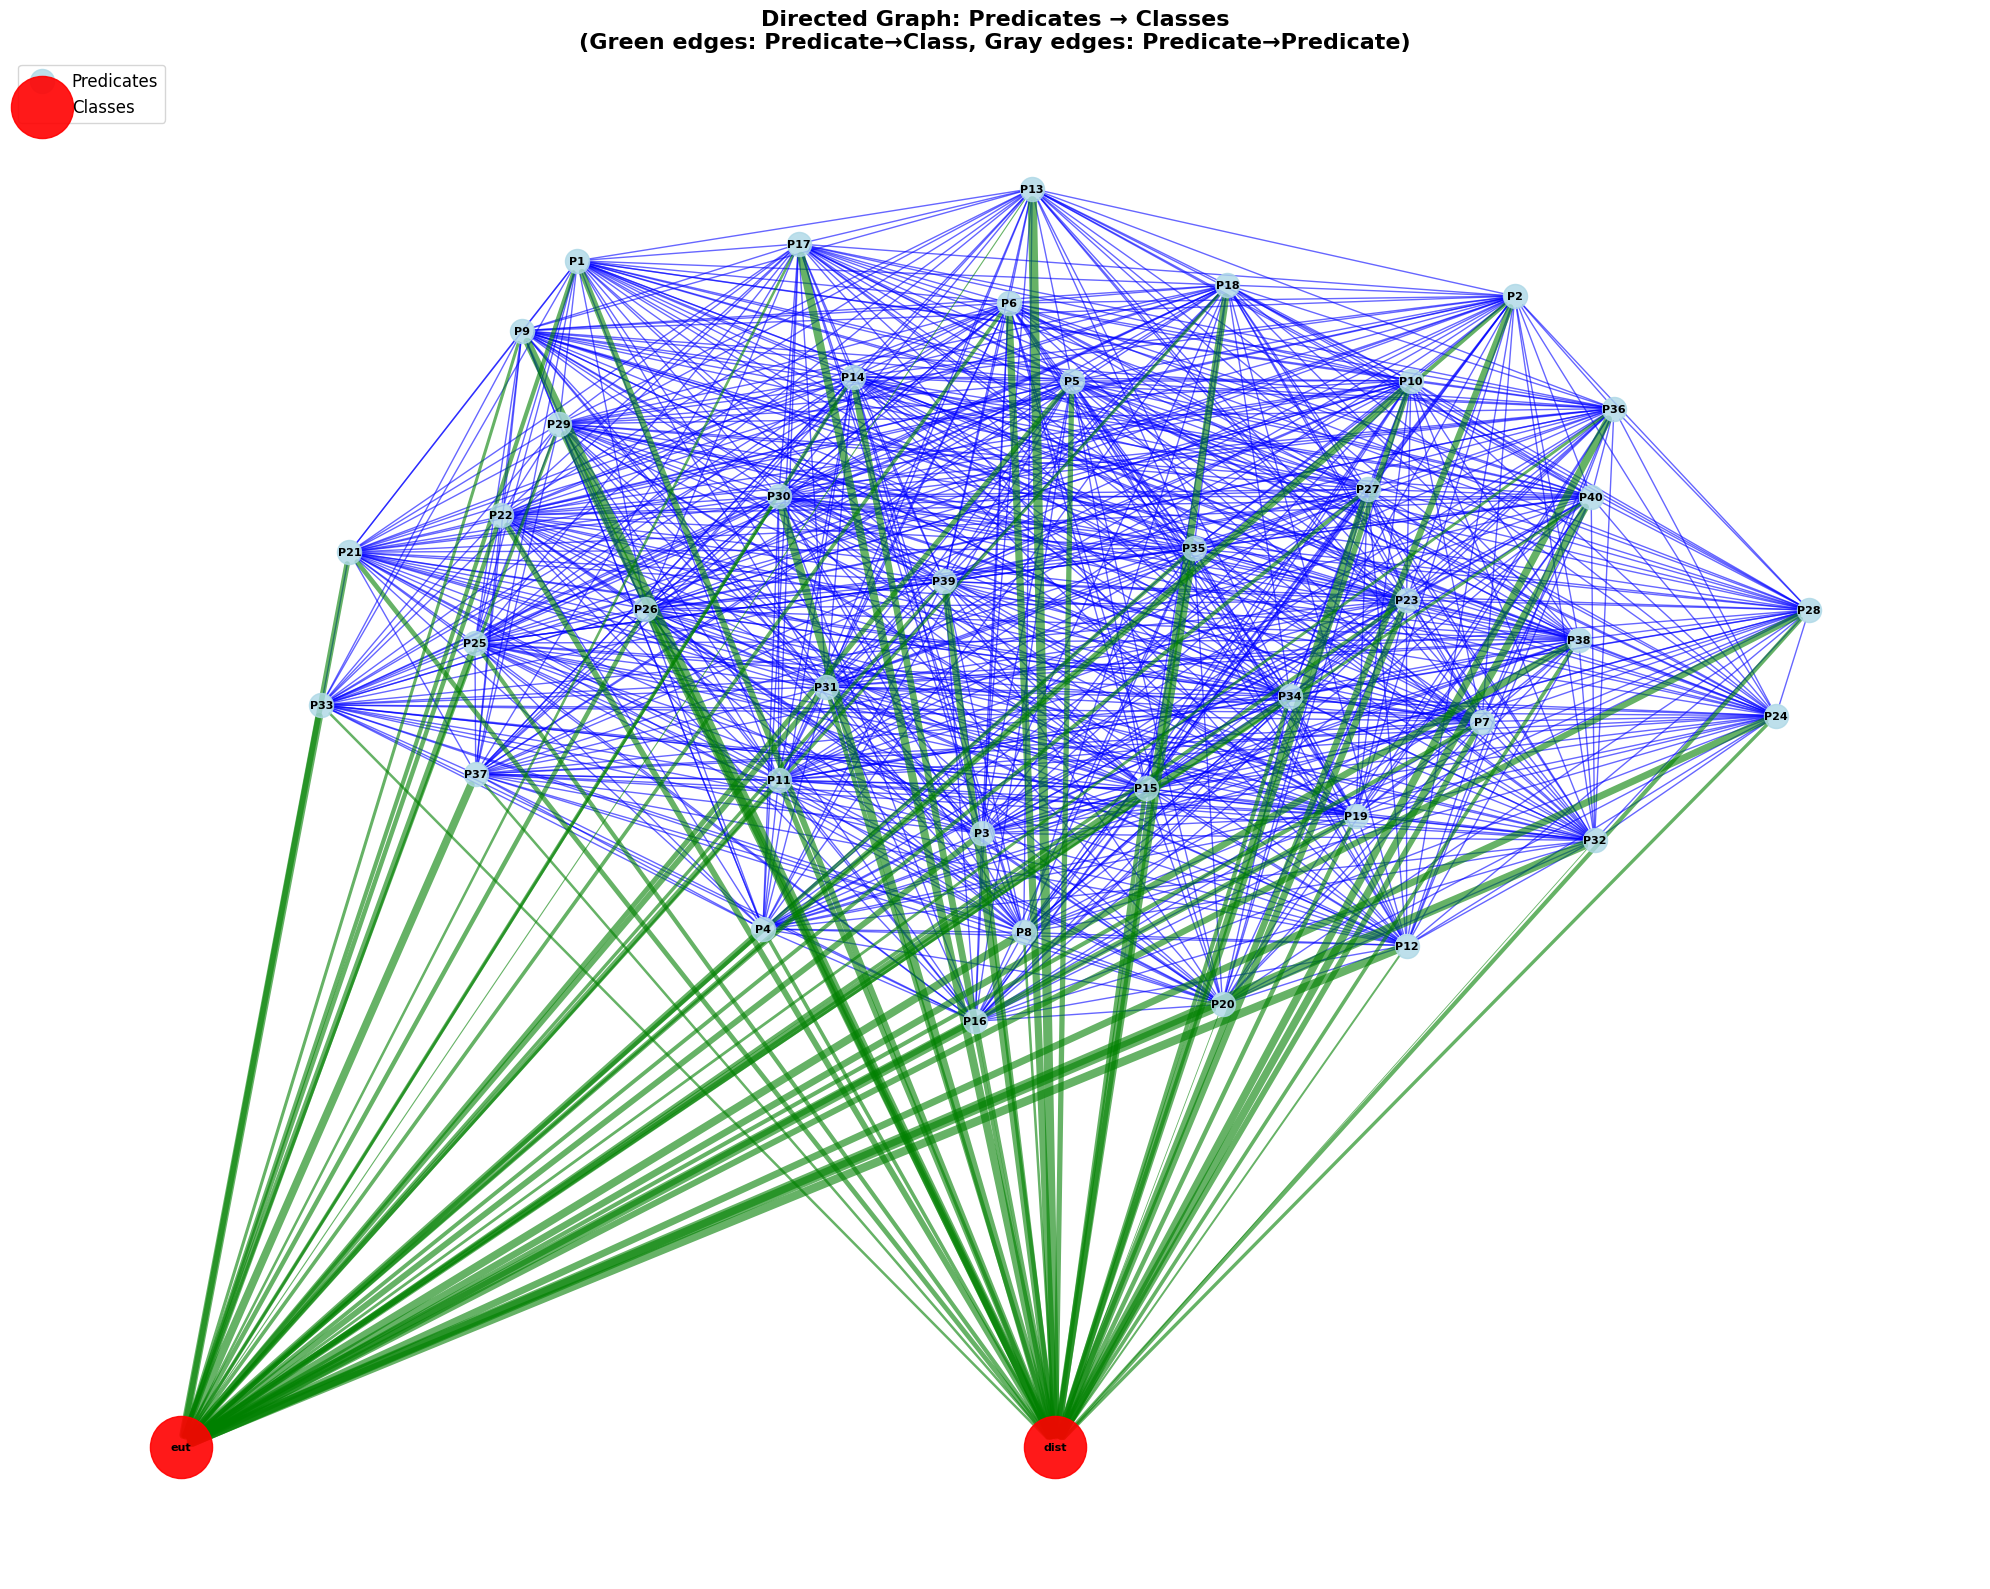

- Green edges show paths from predicates to classes (thickness = number of samples)
- Gray edges show conditional relationships between predicates


In [97]:
import networkx as nx

# Creating an empty graph
G = nx.Graph()

# Adding nodes and edges based on predicates and classes
# Getting predicates from the predicate indicator DataFrame (columns except 'Class_predicted')
predicados = list(predicate_indicator_df.columns[1:])
for predicado in predicados:
    G.add_node(predicado, node_type='predicate')  # Adding each predicate as a node with attribute

# Passo 2: Adicionar nós das classes
# Obtém as classes únicas da coluna 'Class_predicted'
classes = predicate_indicator_df['Class_predicted'].unique()
for classe in classes:
    G.add_node(classe, node_type='class')  # Adiciona cada classe como um nó com atributo

# Passo 3: Adicionar arestas entre predicados (Predicado → Predicado)
# Peso da aresta = quantidade de amostras que satisfazem ambos os predicados
contador_arestas_pred = 0
for i, pred_i in enumerate(predicados): # iterando sobre os predicados
    for pred_j in predicados[i+1:]:  # Evita duplicatas e auto-loops usando i+1
        # Obtém o valor da matriz de co-ocorrência para os dois predicados
        peso = co_occurrence_matrix_df.loc[pred_i, pred_j] # peso da aresta
        
        # Adiciona aresta apenas se houver pelo menos uma amostra em comum
        if peso > 0:
            G.add_edge(pred_i, pred_j, weight=peso, edge_type='pred-pred')
            contador_arestas_pred += 1

# Passo 4: Adicionar arestas entre predicados e classes (Predicado → Classe)
# Peso da aresta = quantidade de amostras que satisfazem o predicado E foram classificadas naquela classe
contador_arestas_classe = 0
for predicado in predicados: # iterando sobre os predicados
    for classe in classes: # iterando sobre as classes
        # Conta quantas amostras satisfazem o predicado (valor = 1) E foram classificadas na classe
        peso = predicate_indicator_df[ # peso da aresta
            (predicate_indicator_df[predicado] == 1) & # satisfaz o predicado
            (predicate_indicator_df['Class_predicted'] == classe) # e pertence à classe
        ].shape[0]
        
        # Adiciona aresta apenas se houver pelo menos uma amostra
        if peso > 0:
            G.add_edge(predicado, classe, weight=peso, edge_type='pred-class')
            contador_arestas_classe += 1

# Resumo do grafo
print(f"\nResumo do Grafo:")
print(f"- Total de nós: {G.number_of_nodes()}")
print(f"- Total de arestas: {G.number_of_edges()}")
print(f"- Nós de predicados: {len(predicados)}")
print(f"- Nós de classes: {len(classes)}")

import matplotlib.pyplot as plt 


fig, ax = plt.subplots(figsize=(20, 16)) # criando a figura e o eixo

predicate_nodes = [n for n in G.nodes() if G.nodes[n]['node_type'] == 'predicate'] # lista de nós de predicados
class_nodes = [n for n in G.nodes() if G.nodes[n]['node_type'] == 'class'] # lista de nós de classes

pos = nx.spring_layout(G, k=2, iterations=50, seed=42) # layout de primavera para melhor espaçamento 
# o k é um parâmetro que afeta a distância entre os nós
# quanto maior o k, maior a distância entre os nós
# o iterations é o número de iterações para o algoritmo de layout

min_y = min([pos[n][1] for n in pos]) # encontrar a posição y mínima para ajustar os nós de classe
# Ajustar posições dos nós de classe para ficarem alinhados na parte inferior
for i, classe in enumerate(class_nodes): # iterando sobre os nós de classe
    pos[classe] = (i - len(class_nodes)/2, min_y - 1)  # posicionando na parte inferior

# o draw_networkx_nodes e draw_networkx_edges desenham os nós e arestas do grafo
nx.draw_networkx_nodes(G, pos, 
                       nodelist=predicate_nodes,
                       node_color='lightblue',
                       node_size=300,
                       alpha=0.8,
                       label='Predicates')
nx.draw_networkx_nodes(G, pos,
                       nodelist=class_nodes,
                       node_color='red',
                       node_size=2000,
                       alpha=0.9,
                       label='Classes')

# o draw_networkx_edges desenha as arestas do grafo
# Predicate → Predicate edges (gray, thinner)
pred_pred_edges = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'pred-pred'] # selecionando as arestas de predicado para predicado
nx.draw_networkx_edges(G, pos,
                       edgelist=pred_pred_edges,
                       edge_color='blue',
                       alpha=0.6,
                       #width=0.5,
                       arrows=True,
                       arrowsize=10)

# Predicate → Class edges (green, thicker, weighted by count)
pred_class_edges = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'pred-class']
edge_weights = [G[u][v]['weight']/5 for u, v in pred_class_edges]  # Scale for visualization
nx.draw_networkx_edges(G, pos,
                       edgelist=pred_class_edges,
                       edge_color='green',
                       alpha=0.6,
                       width=edge_weights,
                       arrows=True,
                       arrowsize=15)

# o draw_networkx_labels desenha os rótulos dos nós
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# adicionando título e legenda
plt.title('Directed Graph: Predicates → Classes\n(Green edges: Predicate→Class, Gray edges: Predicate→Predicate)', 
          fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()
print(f"- Green edges show paths from predicates to classes (thickness = number of samples)")
print(f"- Gray edges show conditional relationships between predicates")

#  **Directed Graph based on VIP scores**

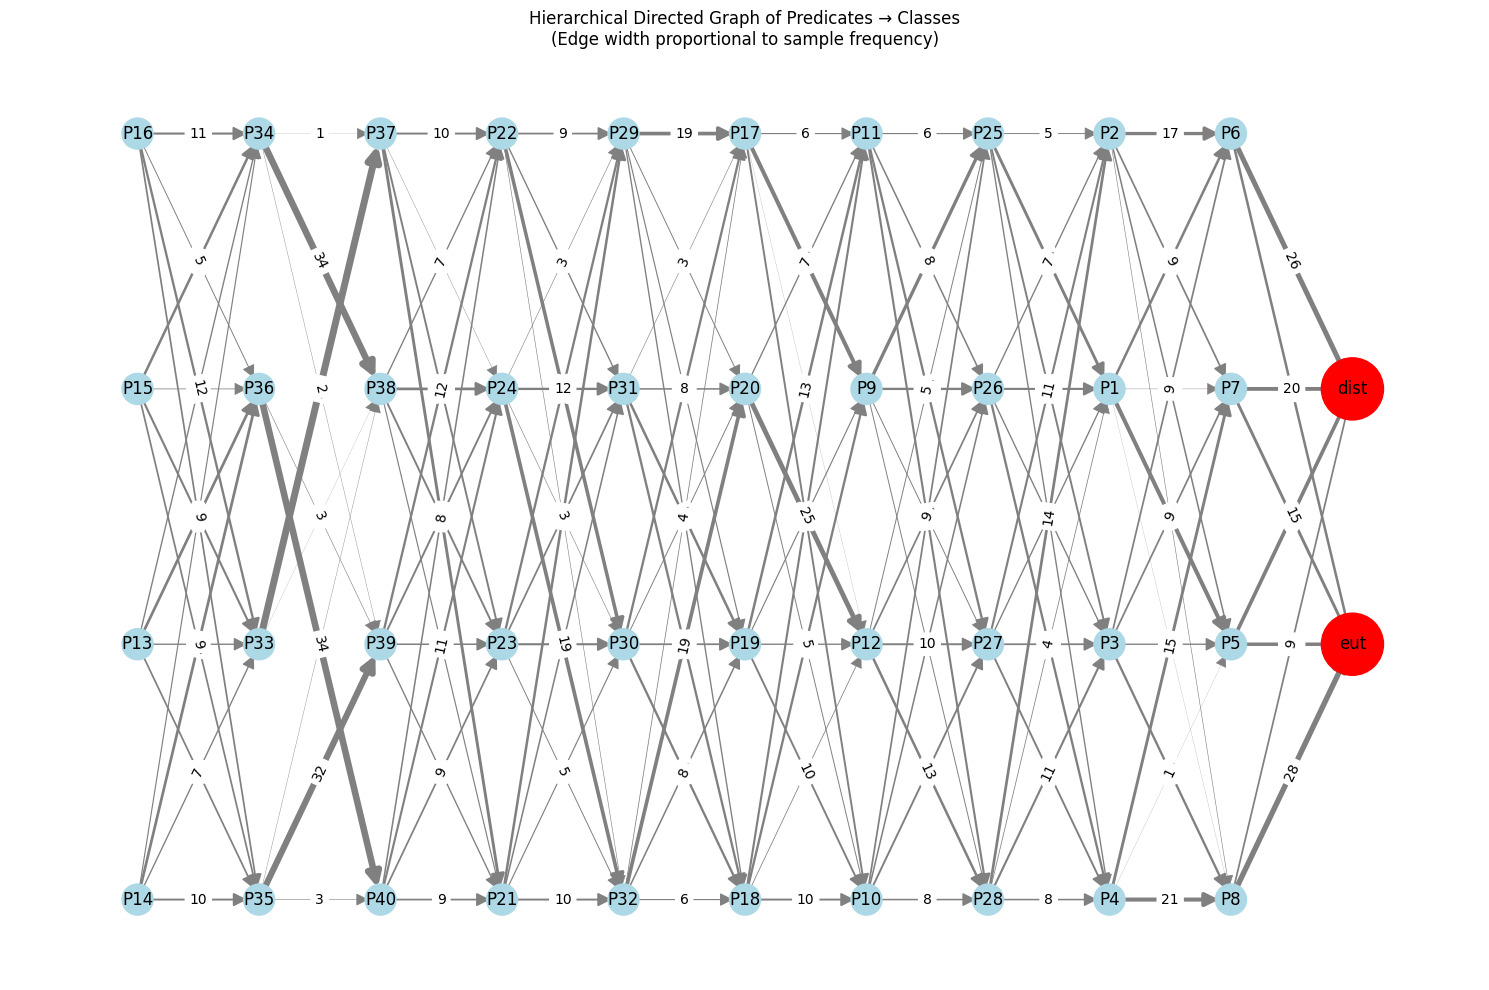


Métricas do Grafo:
Número de nós: 42
Número de arestas: 144
Densidade do grafo: 0.084

Caminhos mais frequentes:

Para classe eut:
- P13 → P33 → P37 → P22 → P30 → P20 → P12 → P28 → P3 → P8 → eut
- P13 → P33 → P37 → P22 → P30 → P20 → P12 → P28 → P3 → P6 → eut
- P13 → P33 → P37 → P22 → P30 → P20 → P12 → P28 → P3 → P5 → eut

Para classe dist:
- P13 → P33 → P37 → P22 → P30 → P20 → P12 → P28 → P3 → P8 → dist
- P13 → P33 → P37 → P22 → P30 → P20 → P12 → P28 → P3 → P6 → dist
- P13 → P33 → P37 → P22 → P30 → P20 → P12 → P28 → P3 → P5 → dist


In [98]:
import networkx as nx

# 1. Criar hierarquia baseada em VIP scores
def create_predicate_hierarchy(zone_vip_sums_df, predicates_df):
    # Ordenar zonas por VIP score acumulado
    zone_order = zone_vip_sums_df.mean().sort_values(ascending=False).index
    
    # Criar dicionário de níveis para cada predicado
    predicate_levels = {}
    current_level = 0
    
    for zone in zone_order:
        # Pegar predicados desta zona
        zone_predicates = predicates_df[predicates_df['zone'] == zone]['predicate'].tolist()
        for pred in zone_predicates:
            predicate_levels[pred] = current_level
        current_level += 1
    
    return predicate_levels

# 2. Criar grafo direcionado
DG = nx.DiGraph()

# 3. Adicionar nós com atributos de nível
predicate_levels = create_predicate_hierarchy(zone_vip_sums_df, predicates_df)
for pred, level in predicate_levels.items():
    DG.add_node(pred, level=level, type='predicate')

# 4. Adicionar nós de classe com nível máximo + 1
classes = predicate_indicator_df['Class_predicted'].unique()
max_level = max(predicate_levels.values())
for cls in classes:
    DG.add_node(cls, level=max_level + 1, type='class')

# 5. Criar arestas baseadas em caminhos de amostras
for idx in predicate_indicator_df.index:
    # Obter predicados ativos para esta amostra
    active_preds = predicate_indicator_df.iloc[idx, 1:][predicate_indicator_df.iloc[idx, 1:] == 1].index.tolist()
    sample_class = predicate_indicator_df.iloc[idx, 0]
    
    # Ordenar predicados por nível
    active_preds.sort(key=lambda x: predicate_levels[x])
    
    # Criar arestas entre predicados consecutivos
    for i in range(len(active_preds)-1):
        pred1, pred2 = active_preds[i], active_preds[i+1]
        if predicate_levels[pred1] <= predicate_levels[pred2]:  # Manter DAG
            if DG.has_edge(pred1, pred2):
                DG[pred1][pred2]['weight'] += 1
            else:
                DG.add_edge(pred1, pred2, weight=1)
    
    # Conectar último predicado à classe
    if active_preds:
        last_pred = active_preds[-1]
        if DG.has_edge(last_pred, sample_class):
            DG[last_pred][sample_class]['weight'] += 1
        else:
            DG.add_edge(last_pred, sample_class, weight=1)

# 6. Visualização
plt.figure(figsize=(15, 10))

# Posicionamento por níveis
pos = nx.multipartite_layout(DG, subset_key='level', align='vertical')

# Desenhar nós
nx.draw_networkx_nodes(DG, pos, 
                      node_color=['red' if d['type']=='class' else 'lightblue' 
                                for n, d in DG.nodes(data=True)],
                      node_size=[2000 if d['type']=='class' else 500 
                               for n, d in DG.nodes(data=True)])



# Desenhar arestas com espessura proporcional ao peso
edges = DG.edges(data=True)
weights = [d['weight'] for _, _, d in edges]
nx.draw_networkx_edges(DG, pos, width=[w/max(weights)*5 for w in weights],
                      edge_color='gray', arrows=True, arrowsize=20)

# Adicionar rótulos de peso nas arestas
edge_labels = {(u, v): d['weight'] for u, v, d in DG.edges(data=True)}
nx.draw_networkx_edge_labels(DG, pos, edge_labels, font_size=10)

# Adicionar rótulos
nx.draw_networkx_labels(DG, pos)

plt.title("Hierarchical Directed Graph of Predicates → Classes\n(Edge width proportional to sample frequency)")
plt.axis('off')
plt.tight_layout()
plt.show()

# 7. Análise de métricas do grafo
print("\nMétricas do Grafo:")
print(f"Número de nós: {DG.number_of_nodes()}")
print(f"Número de arestas: {DG.number_of_edges()}")
print(f"Densidade do grafo: {nx.density(DG):.3f}")
print("\nCaminhos mais frequentes:")
for cls in classes:
    paths = list(nx.all_simple_paths(DG, source=list(DG.nodes())[0], target=cls))
    if paths:
        print(f"\nPara classe {cls}:")
        for path in paths[:3]:  # Top 3 caminhos
            print(f"- {' → '.join(path)}")

In [99]:
# Calculate local reaching centrality for all nodes
local_centrality = {node: nx.local_reaching_centrality(DG, node) for node in DG.nodes()}
pd.DataFrame.from_dict(local_centrality, orient='index', columns=['Local Reaching Centrality']).sort_values(by='Local Reaching Centrality', ascending=False)

Local Reaching Centrality
P13                    0.926829
P14                    0.926829
P15                    0.926829
P16                    0.926829
P34                    0.804878
P35                    0.804878
P33                    0.780488
P36                    0.780488
P37                    0.731707
P38                    0.731707
P39                    0.731707
P40                    0.731707
P21                    0.634146
P22                    0.634146
P23                    0.634146
P24                    0.634146
P29                    0.536585
P30                    0.536585
P31                    0.536585
P32                    0.536585
P17                    0.439024
P18                    0.439024
P19                    0.439024
P20                    0.414634
P9                     0.341463
P10                    0.341463
P11                    0.341463
P12                    0.341463
P25                    0.243902
P26                    0.243902
P27                    0.243902
P28                    0.243902
P1                     0.146341
P2                     0.146341
P3                     0.146341
P4                     0.121951
P5                     0.048780
P6                     0.048780
P7                     0.048780
P8                     0.048780
eut                    0.000000
dist                   0.000000

In [100]:
# Calculating betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(DG)
pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['Betweenness Centrality']).sort_values(by='Betweenness Centrality', ascending=False)

Betweenness Centrality
P19                 0.058740
P17                 0.058740
P18                 0.058740
P10                 0.054776
P11                 0.054776
P12                 0.054776
P30                 0.053659
P29                 0.053659
P31                 0.053659
P32                 0.053659
P23                 0.047561
P24                 0.047561
P21                 0.047561
P22                 0.047561
P39                 0.043293
P38                 0.043293
P20                 0.043293
P27                 0.042683
P25                 0.042683
P28                 0.042683
P26                 0.042683
P9                  0.040549
P1                  0.031545
P3                  0.031545
P2                  0.031545
P37                 0.029878
P40                 0.029878
P34                 0.024797
P35                 0.024797
P4                  0.022439
P36                 0.016667
P33                 0.016667
P5                  0.011728
P7                  0.011728
P8                  0.011728
P6                  0.008720
P13                 0.000000
P14                 0.000000
P16                 0.000000
P15                 0.000000
eut                 0.000000
dist                0.000000